# Assignment 5

A dataset is modeled using ANN, RNN, and LSTM to investigate the performance differences between the different models. The objectives are:
1. To build ANN, RNN, and LSTM models for the same data
2. To select and justify the best approach for the data
3. To investigate model improvement through hyperparameter tuning

## Building and Comparing Models

First, the relevant libraries are imported. Also, a function is defined such that it creates a tuple of new numpy arrays that return:
* Input sequence up to **d_steps** as input
* Input record **d_steps + 1** as output

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, SimpleRNN, LSTM
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

ModuleNotFoundError: No module named 'scikeras'

In [ ]:
import scikeras
print(scikeras.__version__)

0.13.0


In [2]:
def create_sequence_data(sequence, d_steps):
    X,y = [], []
    for i in range(len(sequence) - d_steps):
        X.append(sequence[i:i + d_steps])
        y.append(sequence[i + d_steps])
    return np.array(X), np.array(y)

A trivial function is built to take the specified score history and print each instance, and the overall average to assess the stochastically independent performance of the model.

In [3]:
def scores(score_array, name):
    for count, score in enumerate(score_array,start=1):
        print(f"{name} for Run {count} = {score:.3f}")
        
    print(f"The average {name} is: {np.mean(score_array):.3f}")

Then, the provided data is loaded into a numpy array, and the input/output variables are fed the sequence as defined by the **create_sequence_data** function.

In [6]:
inp = np.load("data_lstm.npz")
print(inp)
data_in = inp['arr_0']
print(data_in.shape)

d_steps = 3
X, y = create_sequence_data(data_in,d_steps)

NpzFile 'data_lstm.npz' with keys: arr_0
(100,)


Each model training setup is run 5 times and the average performance or losses are recorded to filter out the stochasticity of training process.

### Simple Feed-Forward Neural Network (FFNN) / Multi Layer Perceptrons (MLP)

For a simple FFNN/MLP, **(batch_size, d_steps, n_features)**, i.e. the standard 3D input for RNNs, is not valid. Upon forced input of a 3-dimensional input, the Dense layer interprets each data in sequence_length as different training data, essentially flattening the 3D-input to 2D as (batch_size * sequence_length). The model will then proceed to train and test for each data in the sequence instead of using the number of sequence data to predict the next sequence value. Also, since a single value of output is fed, all predictions in the sequence will be compared to that singular target value to evaluate the loss, which is not the objective.

Therefore, to mimic the RNN behavior, the data is fed as n_features = sequence_length * n_features instead for the case of MLP-ANN. Then, the model is built using the code below.

loss for Run 1 = 0.007
loss for Run 2 = 0.003
loss for Run 3 = 0.003
loss for Run 4 = 0.002
loss for Run 5 = 0.008
The average loss is: 0.005


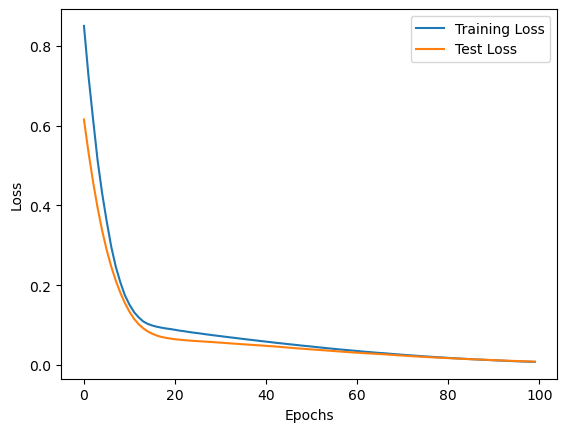

In [6]:
X = X.reshape(X.shape[0], X.shape[1])
n_features = X.shape[1]
loss_array = []


for i in range(5):
    model = Sequential([
        Input(shape=(n_features,)),
        Dense(64, activation="relu"),
        Dense(1)
    ])
    
    model.compile(optimizer="adam", loss="mse")
    history = model.fit(X,y, verbose=0, epochs=100, validation_split=0.2)
    loss_array.append(history.history["val_loss"][-1])

scores(loss_array, "loss")
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Test Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

### Simple Recurrent Neural Network (RNN)

The RNN architecture allows a feed-back loop that can feed sequential data directly into its architecture. Therefore, the 3-dimensional input needs reshaping to the standard form of **(n_records, d_steps, n_features)**. Since this a case of a single sequence, the n_features = 1 by default.

In [7]:
X = X.reshape(X.shape[0], X.shape[1],1)

Then, the model is built with **Input(shape=(d_steps, n_features))**, where the batch (first dimension) is internally handled by keras.

Loss for Run 1 = 0.002
Loss for Run 2 = 0.001
Loss for Run 3 = 0.000
Loss for Run 4 = 0.001
Loss for Run 5 = 0.001
The average Loss is: 0.001


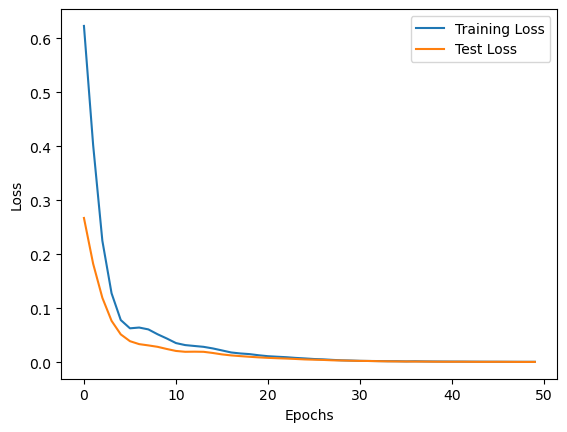

In [8]:
n_features = 1
loss_array = []

for i in range(5):
    model = Sequential([
        Input(shape=(d_steps, n_features)),
        SimpleRNN(64, activation="relu"),
        Dense(1)
    ])
    
    model.compile(optimizer="adam", loss="mse")
    history = model.fit(X,y, verbose=0, epochs=50, validation_split=0.2)
    loss_array.append(history.history["val_loss"][-1])

scores(loss_array, "Loss")
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Test Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

### Long Short Term Memory (LSTM)

Finally, the same input dimension of RNN is fed to the LSTM model. Essentially, this is just an architecture upgrade for the RNN to a better gradient handling LSTM model.

Loss for Run 1 = 0.041
Loss for Run 2 = 0.043
Loss for Run 3 = 0.045
Loss for Run 4 = 0.047
Loss for Run 5 = 0.054
The average Loss is: 0.046


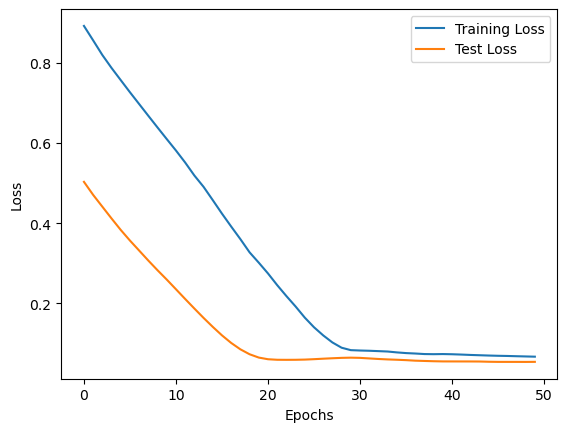

In [9]:
n_features = 1
loss_array = []

for i in range(5):
    model = Sequential([
        Input(shape=(d_steps, n_features)),
        LSTM(64, activation="relu"),
        Dense(1)
    ])
    
    model.compile(optimizer="adam", loss="mse")
    history = model.fit(X,y, verbose=0, epochs=50, validation_split=0.2)
    loss_array.append(history.history["val_loss"][-1])
    
scores(loss_array, "Loss")
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Test Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

The best model from the three architectures is the RNN model due to the least losses achieved from an identical number of hidden layers and input-sequence pair compared to the ANN and the LSTM models. This is likely due to the relatively less number of lookbacks at history data, i.e. sequence lenght of 3, that does not entirely need LSTM to acoount for gradient vanishing or exploding problems. 

As for the ANN, the setup effectively trains different weights for each input in sequence without necessarily respecting the time dependencies of the data. However, given the small sample size, ANN might have found a good enough pattern to be both trained and validated upon effectively. At a larger scale, this might not be true.

## Hyperparameter Tuning

The LSTM model has been chosen for hyperparameter tuning, provided the other two already do well with the current architecture. Improvements to all the models can be similarly made. The following parameter grid has been searched for in this case.

In [10]:
hid_neu = [32, 64, 128]
learning_rate = [0.001, 0.005]

import itertools
params = list(itertools.product(hid_neu, learning_rate))

A simple grid-search algorithm has been implemented as:

In [11]:
opt_config = []
opt_mse = 100

for hn, lr in params:
    loss_array=[]
    for i in range(5):
        model = Sequential([
            Input(shape=(d_steps, n_features)),
            LSTM(hn, activation="relu"),
            Dense(1)
        ])
            
        model.compile(optimizer=Adam(learning_rate=lr), loss="mse")
        history = model.fit(X,y, verbose=0, epochs=50, validation_split=0.2)
        loss_array.append(history.history["val_loss"][-1])
    
    if np.mean(loss_array) < opt_mse:
        opt_mse = np.mean(loss_array)
        opt_config = [hn, lr]
        print(f"{opt_config} with loss = {opt_mse:.3f}")

print()
print("Overall Optimum Configuration:")
print(opt_config)

[32, 0.001] with loss = 0.050
[32, 0.005] with loss = 0.005
[64, 0.005] with loss = 0.003

Overall Optimum Configuration:
[64, 0.005]


In [12]:
print(f"Therefore, the optimal configuration for LSTM is with {opt_config[0]} neurons in hidden layer and a learning rate of {opt_config[1]} for the adam optimizer")

Therefore, the optimal configuration for LSTM is with 64 neurons in hidden layer and a learning rate of 0.005 for the adam optimizer


### Impact of hyperparameters on the model

Increasing the learning rate to 0.005 seems to provide better fit-results for all cases of LSTM for this data. As for the number of neurons in the hidden layer, increasing from 32 to 64 achieves better results, but with further increase to 128, the model performance worsens.